In [9]:
%matplotlib inline

from matplotlib import gridspec
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from numpy.random import rand
from pylab import rcParams, pcolor, show, colorbar, xticks, yticks, title, figure

rcParams['figure.figsize'] = (14, 7)

## Time Series statistics

As we saw in previous exmaples, it is possible to have two time series that have completely different character, but the same univariate statistics.  i.e. their underlying probability distribution densities can be exactly the same, but the ordering of the data matters.  

Here we define the meaning of a **Stationary Time Series** and discuss one of the most straight forward way of characterizing the relation of that time series in time, the **Spectral Density**.

### Motivating Example

Its helpful to have a simple example to think about as we go through this material.  Here we will consider the sum of two sine waves with Normally distributed noise on top of it:

\begin{equation}
    x = A_1\cos \left(\omega_1 t+\phi_1\right)+A_2\cos \left(\omega_2 t+\phi_2\right) + n(t)
\end{equation}

In [2]:
# first sine wave
t = np.arange(0.,30.,0.01)
A1 = 1.;  om1 = 2.*np.pi/1.;  ph1=0.
x1 = A1*np.cos(om1*t+ph1)

# second sine wave
A2 = 0.7;   om2 = 2.*np.pi/3.;   ph2=0.3
x2 = A2*np.cos(om2*t+ph2)
# Noise
n=1.*np.random.randn(len(t))

x=x1+x2+n #sum of the two sines plus noise

In [4]:
def fig1():
    fig=plt.figure()
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
    ax=fig.add_subplot(gs[0])
    ax.plot(t,x)
    ax.set_xlabel('t [s]');ax.set_ylabel('x [units]');
    ax=fig.add_subplot(gs[1])
    n,bins,pa=ax.hist(x,70,orientation='horizontal',histtype='step',cumulative=True,normed='True',label='pdf x')
    norm = stats.norm.cdf(bins,loc=np.mean(x),scale=np.std(x)) # normal distribution with same mean and std of x.
    ax.plot(norm,bins,'k--',label='Normal dist')
    ax.set_xlabel('CDF(x)');
    ax.legend(fontsize='small',loc=4,frameon=False)
    print(np.mean(x),np.var(x))

0.011678157103489592 1.773775014918065


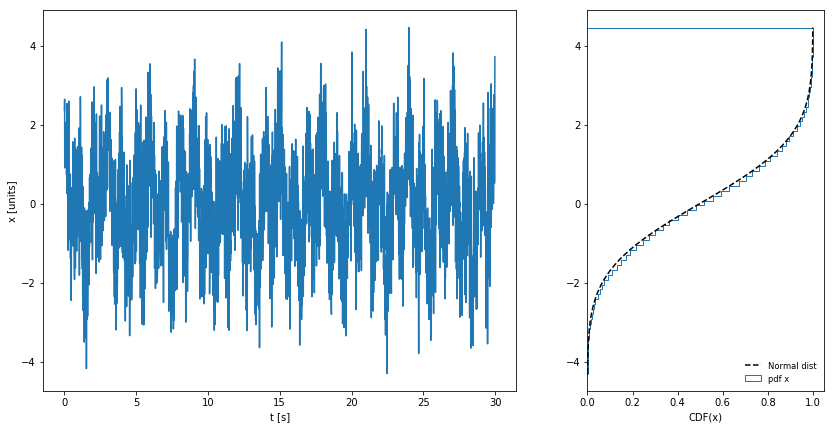

In [10]:
fig1()

None of the techniques we have discussed so far will reveal the presence of the two sine waves embedded in the data $x$. In fact the cumulative distribution of this data looks a lot like the normal distribution. The mean and the standard deviation of a time series are often very useful to know, but clearly we are still missing a lot if we stop there.  

If we had a good regression model that would indicate the two sine waves, we could easily do a non-linear fit for the waves.  Note that this would entail fitting six parameters ($A_1,\omega_1,\phi_1,A_2,\omega_2,\phi_2$), but what if there were more sine waves?


Rather it would be nice to characterize this time series without any *a-priori* knowledge or hypothesized model.  With that in mind, lets consider the definition of a time-series, and one simple method to characterize their temporal information, the lagged correlation.

### Stochastic Processes

The formal definition of a **stochastic process** or a **Random process** is analagous to the definition of a random variable.  A realization of a random variable $\{x\}$ is a *sample* from the probability density function $p(x)$.  

A realization of a stochastic process is a *sample* time series $x_k(t)$ from a random process that is continuous in time, and can be characterized by a probability structure that is common to all realizations. Different realizations of this process would look different, but they would all have the same statistical character.  

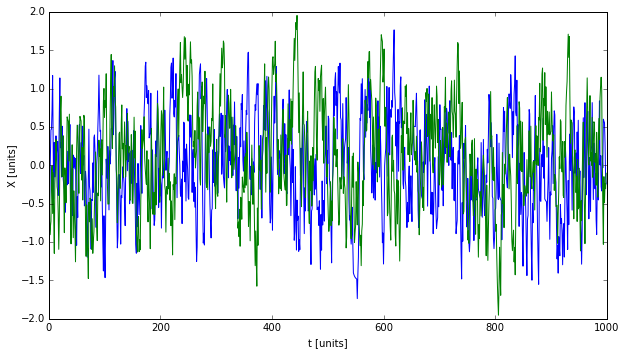

In [209]:
Nt = 1000 
x1=np.zeros(Nt) #first realization 
x2=np.zeros(Nt) #second realization 
for i in range(1,Nt):
    x1[i]=0.75*(x1[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5)
    x2[i]=0.75*(x2[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5)
fig,ax=plt.subplots(1,1)
ax.plot(x1);ax.plot(x2);ax.set_xlabel('t [units]');ax.set_ylabel('X [units]')

All the momments from univariate statistics can be computed, but now they are time series.  i.e. the mean

\begin{equation}
  \mu_x(t)=E (x(t))
\end{equation}

Note that $\mu_x(t)$ is a time series itself and can theoretically evolve in time.  Imagine the process above, but with a steady trend added to both of the variables:

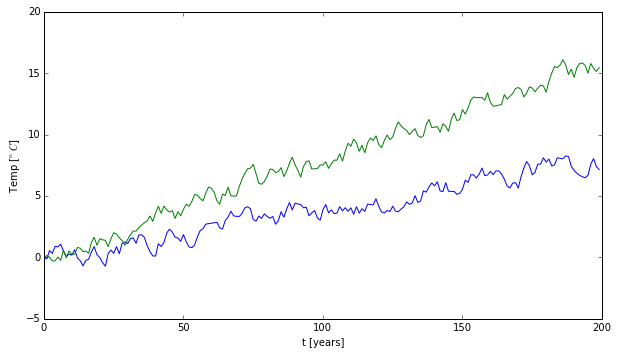

In [210]:
Nt = 200
x1=np.zeros(Nt)
x2=np.zeros(Nt)
for i in range(1,Nt):
    x1[i]=0.75*(x1[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5)+i/100.
    x2[i]=0.75*(x2[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5)+i/50.
fig,ax=plt.subplots(1,1)
ax.plot(x1);ax.plot(x2);ax.set_xlabel('t [years]');ax.set_ylabel('Temp [$^oC$]')

Here, it is easy to see that the mean of the time series increases with time.  Similarly we can imagine a stochastic process for which the variance increases or is modulate in time:

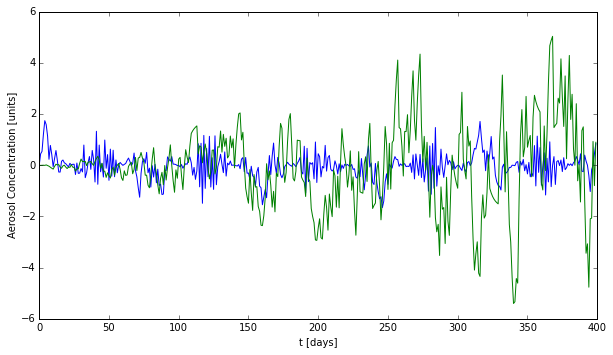

In [211]:
Nt = 400
x1=np.zeros(Nt)
x2=np.zeros(Nt)
for i in range(1,Nt):
    x1[i]=(0.75*(x1[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5))*1.2*np.cos((2.*np.pi/80)*i)
    x2[i]=0.75*(x2[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5)*i/100.
fig,ax=plt.subplots(1,1)
ax.plot(x1);ax.plot(x2);ax.set_xlabel('t [days]');ax.set_ylabel('Aerosol Concentration [units]')

## Lag Covariance 

There are a number of ways to characterize time series.  First, the momments for univariate statistics can be used, where the mean, variance, skewness, etc are all time series themselves, i.e., for variance

\begin{equation}
    \sigma_{x}^2(t) = \int_{-\infty}^{\infty} p(x,t) (x(t)-\mu_x(t))^2\ \mathrm{d}x
\end{equation}

However, this does not tell us anything about the relatedness of the time series in time.  In our original example, the time series had memory of the previous times and it is necessary to have a statistic that reflects this. 

The lowest order statistic is the **lag auto-covariance** for comparing $x$ with itself and the **lag covariance** for comparing $x(t)$ with $y(t)$:

\begin{align}
    C_{xx}(t,t+\tau) &= E\left[\left( x_k(t)-\mu_x(t) \right)\left( x_k(t+\tau)-\mu_x(t+\tau) \right) \right]\\
    C_{xy}(t,t+\tau) &= E\left[\left( x_k(t)-\mu_x(t) \right)\left( y_k(t+\tau)-\mu_y(t+\tau) \right) \right]
\end{align}

Note that for $\tau=0$, $C_{xx}(t)=\sigma_x^2(t)$, i.e., is just the variance.  

### Stationary Processes

A process is said to be **Weakly Stationary** if the mean $\mu_x(t)$, and the second-order *lag covariance* $C_{xx}(t,t+\tau)$ are independent of time $t$.  So, in the synthesized time series above, the linearly increasing mean and increasing variance examples are *not* stationary processes.  The original process, however, is.  

A process is said to be **Strongly Stationary** if any possible probability distributions are independent of $t$.  Again, this is rarely tested, and since the higher-order probability distributions are rarely computed, is only of academic value.

There is another special type of *weakly stationary* processes: **ergodic** processes, in which the statistics can be approximated by a subsample of the time series.  As scientists, this is what we usually deal with.  We usually do not know the underlying statistics, and we cannot collect an infinite time series to determine them, so we hope that time averaging will allow us to *estimate* the statistical momments.  Formally a process is **ergodic** if

\begin{align}
    \mu_x(k) &= \lim_{T\to\infty} \frac{1}{T}\int_0^T x(t)\ \mathrm{d}t\\
    C_{xx}(\tau,k) &= \lim_{T\to\infty}  \frac{1}{T}\int_0^T \left( x_k(t)-\mu_x(t) \right)\left( x_k(t+\tau)-\mu_x(t+\tau) \right)\ \mathrm{d}t\\
\end{align}

Practically, its very hard to find a time series that is truly ergodic, too bad.  However, there are various approaches around this

  1. We can ignore the lack of ergodicity, or assume it doesn't affect our results too much (bad idea, but done sometimes!)
  2. We can divide the time series into reasonably ergodic regions. 
  3. We can massage the data to make it more ergodic.
  
In the case where the mean was linearly increasing, we might have removed the long-term trend by a linear fit with time and considered just the deviations from the linear fit:

In [212]:
def fig2():
    Nt = 200
    x1=np.zeros(Nt)
    x2=np.zeros(Nt)
    t = np.arange(Nt)
    for i in range(1,Nt):
        x1[i]=0.75*(x1[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5)+i/100.
        x2[i]=0.75*(x2[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5)+i/100.
    fig,ax=plt.subplots(1,1)
    ax.plot(x1, alpha =0.5);ax.plot(x2, alpha =0.5);ax.set_xlabel('t [years]');ax.set_ylabel('temp [$^oC$]')
    # linear fit:
    from scipy import polyfit 
    ar,br=polyfit(t,x1,1);xf1=br+ar*t
    ar,br=polyfit(t,x2,1);xf2=br+ar*t
    ax.plot(xf1,'b--');ax.plot(xf2,'g--')
    ax.plot(x1-xf1,'b');ax.plot(x2-xf2,'g')

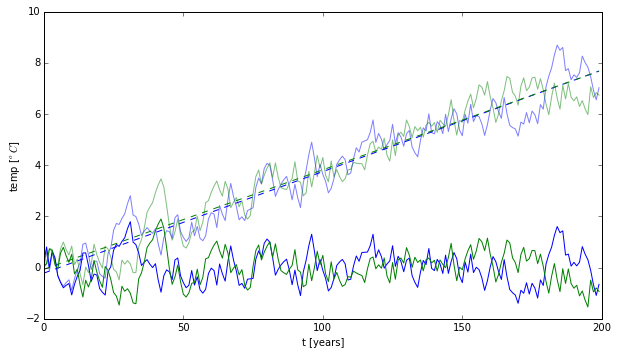

In [213]:
fig2()

The de-trended time series can be considered more ergodic than the original.  

Similarly, if a signal changes its variance suddenly at some point of the time series, it would make sense to analyze the two sections separately.  For real data, the decisions you make should be shown to not strongly affect your results, or at least the effect quantified in some way.  

### Ex: Lag-covariance

Lets compare the lag covariance of our signals to a Normal distributed process that is completely random.

In [214]:
Nt = 2000
x1=np.zeros(Nt)
x2=np.zeros(Nt)
t = np.arange(Nt)
for i in range(1,Nt):
    x1[i]=0.8*(x1[i-1])+0.25*(np.floor(np.random.rand(1)*6)-2.5)
x2=np.random.randn(Nt)*np.std(x1)

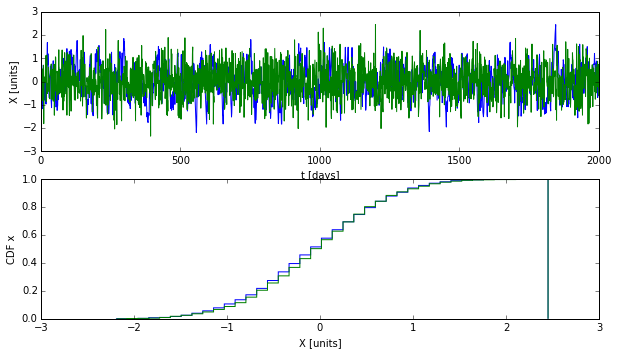

In [215]:
fig,axs=plt.subplots(2,1)
ax=axs[0]
ax.plot(x1);ax.plot(x2);ax.set_xlabel('t [days]');ax.set_ylabel('X [units]')
ax=axs[1]
(n,bins,pa)=ax.hist(x1,bins=40,cumulative=True,histtype='step',normed=True);
ax.hist(x2,bins=bins,cumulative=True,histtype='step',normed=True);
ax.set_xlabel('X [units]');ax.set_ylabel('CDF x')

Here we did the example for a longer time so the lag statistics are robust.  So, now we do the finite version of the integrals

In [216]:
lags = np.arange(-200,200)
cxx1=0.*lags;cxx2=0.*lags
# note that mean(x1)=mean(x2)=0
for ind,tau in enumerate(lags):
    if tau<0:
        cxx1[ind]=np.mean(x1[:tau]*x1[-tau:])
        cxx2[ind]=np.mean(x2[:tau]*x2[-tau:])
    elif tau==0:
        cxx1[ind]=np.mean(x1*x1)
        cxx2[ind]=np.mean(x2*x2)
    else:
        cxx1[ind]=np.mean(x1[:-tau]*x1[tau:])
        cxx2[ind]=np.mean(x2[:-tau]*x2[tau:])
        

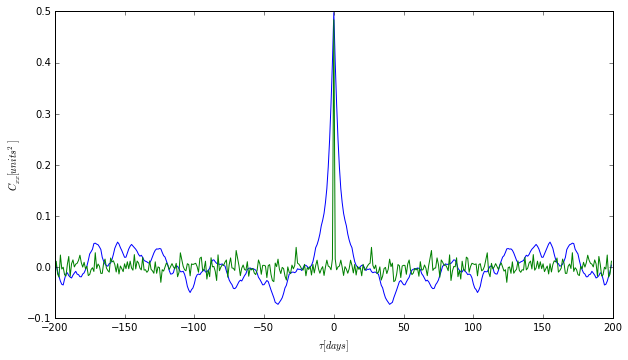

In [217]:
fig,ax=plt.subplots(1,1)
ax.plot(lags,cxx1,lags,cxx2)
ax.set_xlabel(r'$\tau [days]$')
ax.set_ylabel('$C_{xx} [units^2]$')

So, here we can clearly see the structure of the autoregressive signal compared to the completely random uncorrelated signal.  Of course the un-correlated signal has variance, so $C_{xx}>0$ at $\tau=0\ days$, but for other lags, it is just noise.  The auto-covariance of the autoregressive signal shows positive lag covariance up to lags of 50 days or so.

### Math fact:

The **lag correlation** is the same as the **lag covariance** except without the means removed.  So 
\begin{align}
    R_{xx}(\tau) = E\left[x(t)x(t+\tau) \right]\\
    R_{xy}(\tau) = E\left[x(t)y(t+\tau) \right]
\end{align}

If a process is *stationary* then the *lag correlation is symmetric*:

\begin{align}
    R_{xx}(\tau) &= R_{xx}(-\tau)\\
    R_{xy}(\tau) &=R_{yx}(-\tau)
\end{align}

We define he **lag correlation coefficient** as
\begin{equation}
    \rho_{xy}(\tau) = \frac{C_{xy}(\tau)}{\sigma_x\sigma_y}
\end{equation}
and note that $\left|\rho_{xy}(\tau) \leq 1\right|$.  This is likely the more useful quantity than $C_{xy}$ and is usually what is plotted. From the example above, we note that $\rho_{xx}(0)=1$.  

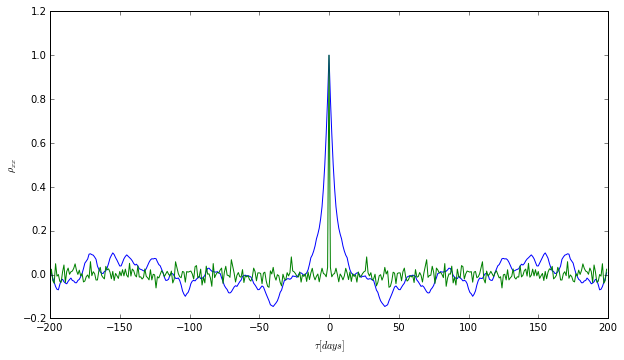

In [218]:
fig,ax=plt.subplots(1,1)
ax.plot(lags,cxx1/np.var(x1))
ax.plot(lags,cxx2/np.var(x2))
ax.set_xlabel(r'$\tau [days]$')
ax.set_ylabel(r'$\rho_{xx}$')

### Ex: Common Processes and their auto-correlations

**Constant in time:** If $x(t)=c$, then the lag auto-correlation is simply $R_{xx}(\tau) = c^2$.  Note that the auto-covariance is $C_{xx}(\tau)=0$.

**Sine wave:** If $x(t)= X \cos(2\pi f+\phi_k)$, where $\phi_k$ is a random phase, then the lag auto-correlation and auto-covariance are $R_{xx}(\tau) = \frac{X^2}{2}\cos\left(2\pi f \tau \right)$

**White Noise:** For a discrete system, white noise can be approximated by a string of uncorrelated random draws from the Normal distribution.  For a continuous system, it is theoretically undefined, though it can be approached.  If we do that, then $\lim_{N\to\infty}R_{xx}(\tau)=\delta(\tau).$  We saw this in the example above.



## Spectral Density Function

The **Spectral Density Function** is a map of energy in a signal as a function of frequency.  It is one of the most useful ways to statistically portray temporal information about a stationary time series.  

Before diving into the definitions, it is useful to take our example and look at the spectral densities.

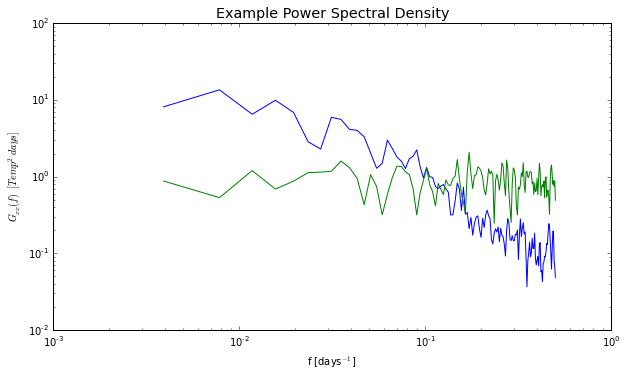

In [219]:
from matplotlib.mlab import psd
p1,f=psd(x1,Fs=1.);  # It is a good practice not to use psd until you prove
                    #it works the same as your code made from scracth.
p2,f=psd(x2,Fs=1.);
fig,ax=plt.subplots(1,1)
ax.loglog(f,p1)
ax.loglog(f,p2)
ax.legend(loc=3);ax.set_title('Example Power Spectral Density',fontsize='x-large')
ax.set_xlabel('f [days$^{-1}$]'); ax.set_ylabel('$G_{xx}(f)\ \ [Temp^2 days]$')

The interpretation is that the random process has equal energy or variance at all frequencies, or scales (white spectrum), while the autoregressive process has a lot more low-frequency energy than high-frequency (red spectrum).  Recall that we set the variance of these two time series to be equal, and as we will see in Parseval's theorem, that means the integral under these two curves is the same, hence they cross in the middle.   

### Definition: From Lag Correlation

There are a couple of ways to get the definition of a power spectra.  The first relates to the Lag Correlation, $R_{xx}$ just discussed.  If we assume $R_{xx}(\tau)$, $R_{yy}(\tau)$ and $R_{xy}(\tau)$ all exist, and that the lag correlations go to zero for large $\tau$, i.e.

\begin{equation}
    \int_{-\infty}^{\infty} \left| R_{xy}(\tau)  \right| \ \mathrm{d}\tau \lt \infty
\end{equation}

then we define the power spectral density function as:

\begin{align}
    S_{xx}(f) & = \int_{-\infty}^{\infty}  R_{xx}(\tau)\ \mathrm{e}^{-\mathrm{j}2\pi f \tau}\,\mathrm{d}\tau \\
    S_{xy}(f) & = \int_{-\infty}^{\infty}  R_{xy}(\tau)\ \mathrm{e}^{-\mathrm{j}2\pi f \tau}\,\mathrm{d}\tau \\
\end{align}

where $j=\sqrt{-1}$.  

The inverse is 

\begin{align}
    R_{xy}(f) & = \int_{-\infty}^{\infty}  S_{xy}(\tau)\ \mathrm{e}^{+\mathrm{j}2\pi f \tau}\,\mathrm{d}\tau \\
\end{align}

A quick note on units.  If $x$ has units of $\mathrm{K}$ (Kelvin), $R_{xx}$ has units of $\mathrm{K}^2$.  If the lag $\tau$ is in days, then $S_{xy}$ has units of $\mathrm{K}^2 \mathrm{days}$ because the interpretation of $S_{xx}(f)$ as a variance density. 

It is possible show that the spectral density is symmetric in $f$:
\begin{equation}
    S_{xx}(-f) = S^*_{xx}(f) = S_{xx}(f)
\end{equation}
\begin{equation}
    S_{xy}(-f) = S^*_{xy}(f) = S_{yx}(f)
\end{equation}
where $S^*_{xy}$ is the complex conjugate of $S_{xy}$.  Note that the first equality means that $S_{xx}$ is real, and symmetric about $f=0$.  

Because we can say that $S_{xx}(-f)=S_{xx}(f)$ it is redundant to consider both sides of $f$, so we usually just look at the **one-sided-spectrum**:

\begin{aligned}
    G_{xx}(f) & \equiv 2 S_{xx}(f) && \text{for } f>0
\end{aligned}

**Note** that since $G_{xx}(f)$ is real then we can also just use the cosine to calculate it from the real correlation function:

\begin{aligned}
    G_{xx}(f) & = 2\int_{-\infty}^{\infty} R_{xx}(\tau)\cos(2\pi f\tau)\ \mathrm{d}\tau\\
    &= 4\int_{0}^{\infty} R_{xx}(\tau)\cos(2\pi f\tau)\ \mathrm{d}\tau\\
\end{aligned}

### Relationship between spectral density and variance of a signal

It should be clear then, that 

\begin{equation}
  R_{xx}(0)=\int_0^{\infty} G_{xx}(f)\ \mathrm{d}f
\end{equation}
i.e. the integral of the area under the spectral density curve is $E\left[x^2\right]$, which if $\mu_x=0$ means 

\begin{equation}
  \sigma_x^2=\int_0^{\infty} G_{xx}(f)\ \mathrm{d}f
\end{equation}

Note that this leads to the natural interpretation that the area under part of the curve between $f$ and $f+\delta f$ is the fraction of variance in that frequency band.

### Quick note on why we decompose into frequency components

Amongst all the math, we can lose sight of why we want to look at $G_{xx}(f)$.  In a linear system, the variance at each $f$ represents the power in a wave at that frequency, hence the name **power spectrum**.  Since waves are such a fundamental natural phenomena, sine waves are a natural way to decompose our signals.

We will see later when we come to finite discrete time series that an appropriately designed set of sines and cosines that fit in the finite time interval comprise a basis of all real functions on that interval.  However the idea is sketched below.  

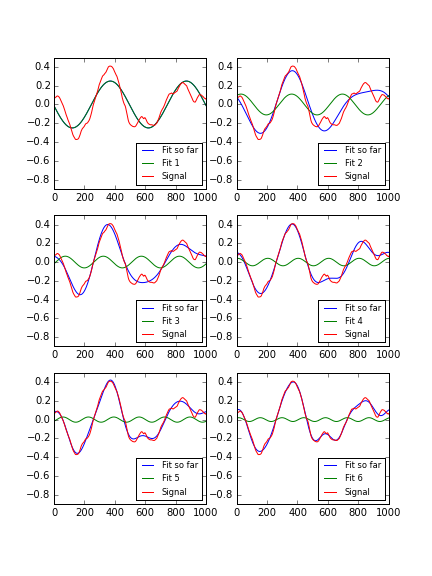

In [220]:
from IPython.display import Image
Image(filename = "/Users/lsiqueira/Desktop/data_analysis_class/Fourierfit.png", width=500, height=50)

The first fit is to the lowest frequency and explains a good proportion of the variance.  The second fit is to the next higher frequency and improves the fit, etc.  For this signal, the sum of the first six fits does quite well at explaining the signal.  

The amplitude squared of these fits are the discrete analogue of $G_{xx}(f)$, and so $G_{xx}(f)$ can be thought of as describing the amplitude of waves that make up the time series $x(t)$.  

### Finite Fourier Transform

We usually only have a finite time series, $x(t)$, $0\leq t \leq T$, however we can define a power spectrum by taking the **Fourier Transform** of our time series.  So for the **cross spectrum**:

\begin{equation}
    S_{xy}(f,T) = \frac{1}{T} X^*(f,T) Y(f,T)
\end{equation}

where

\begin{align}
    X(f,T) & = \int_0^T x(t)\,\mathrm{e}^{-j2\pi ft}\ \mathrm{d}t\\
    Y(f,T) & = \int_0^T y(t)\,\mathrm{e}^{-j2\pi ft}\ \mathrm{d}t\\
\end{align}

Of course the spectrum depends on $T$.

We would like to know how it relates to the true spectrum of the processes, $S_{xy}(f)$, for $x(t)$ and $y(t)$ for all $T$. It is tempting to define

\begin{equation}
    S_{xy}(f) = \lim_{T\to\infty} S_{xy}(f,T)
\end{equation}

however, this is an error given that increasing $T$ does *not* improve the estimate of $S_{xy}(f)$ at any given $f$.  

Instead, we need to recall that $S_{xy}(f,T)$ is a random variable.  Then we can prove that:
\begin{equation}
     S_{x,y}(f)= \lim_{T\to\infty} E\left[ S_{xy}(f,T) \right]
\end{equation}

It is worth keeping in mind that the finite spectrum $S_{xy}(f,T)$ is a statistical estimate of $S_{xy}(f)$, and thus has a distribution associated with each frequency $f$, and therefore confidence intervals. 

### Parseval's Theorem

Parseval's Theorem basically relates the variance of the process to the spectra, as above:

\begin{equation}
    \int_{-\infty}^{\infty} x(t)y(t)\ \mathrm{d}t = \int_{-\infty}^{\infty} X^*(f)Y(f)\ \mathrm{d}f
\end{equation}

The proof of this is relatively easy application of the inverse Fourier transform.  For the special case of $y(t)=x(t)$ we recover the idea that the variance of the process is the integral of the power spectrum:
\begin{equation}
    \int_{-\infty}^{\infty} x^2(t)\ \mathrm{d}t = \int_{-\infty}^{\infty} |X(f)|^2 \ \mathrm{d}f
\end{equation}


### Summary of spectral density

The preceding is a bit theoretical, but the basic ideas should be clear:  

  1. The spectrum is related to the lag correlation by taking a Fourier transform of the lag correlation
  2. The spectrum can also be estimated directly from a finite signal by taking their Fourier transforms and multplying the result.
  2. The expected value finite spectrum derived from the signals approaches the formal spectrum as the sampling period $T$ goes to infinity.
  3. The variance of the signal is equal to the integral of the power spectrum.  